In [15]:
# importing some basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from nltk.corpus import stopwords

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
import datetime

from sklearn.feature_extraction.text import CountVectorizer
import joblib

In [16]:
from tqdm import tqdm
tqdm.pandas()
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
import os
import re

In [17]:
from importlib import reload

In [18]:

from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import spacy 
nlp = spacy.load("en_core_web_lg")

# Load data

In [19]:
dataset = joblib.load('./nonstemmed_labelled_all_states.joblib')
covariates_df = joblib.load('covariates_df.joblib')
foo = covariates_df.iloc[42]

## Scratch for ablation algorithm

In [20]:
#dataset['no_eth'] = dataset.text_reviews.progress_apply(lambda x: remove_eth(x, 'NORP'))

In [21]:
## method 1 - issue is that it causes can't to split into ca n't T___T
def remove_eth_old(review):
    review = " ".join([ent.text for ent in nlp(review) if ent.ent_type_ != 'NORP'])
    return review

In [22]:
remove_eth_old(foo.text_reviews)

"XXXX XXXX Salon and spa was highly recommended to me by a friend and I truly enjoyed every minute of my visit . The girls really make you feel comfortable ; it 's like a mini getaway ! The best part is that they are conveniently located downtown , mobile and I can walk from my office ! // I would highly recommend XXXX XXXX Salon and Spa to anyone looking for a great salon with great service . Crystal did an awesome job on my cut and color . I have never been so pleased leaving a hair appointment as I was when I left XXXX XXXX . I can not wait to go back ! // Mulan and Crystal are down to earth and fun people . I really value their opinions and love the personal touch at this salon . It 's a more intimate setting and they 're very accommodating ! Definitely check it out for a laid back , professional salon experience . // Hard to find two young , professional women in the salon business who are so detail oriented at what they do in this day and age .   I would recommend anyone wanting 

In [23]:
doc = nlp(foo.text_reviews)
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

print(', '.join([e.ent_type_ for e in doc]))

XXXX XXXX Salon 0 19 ORG
every minute 89 101 TIME
XXXX XXXX Salon 313 332 ORG
XXXX XXXX 522 535 ORG
Mulan 566 571 PERSON
Crystal 576 583 PRODUCT
two 840 843 CARDINAL
this day 938 946 DATE
the XXXX XXXX 1016 1033 ORG
XXXX XXXX 1102 1108 GPE
ORG, ORG, ORG, ORG, , , , , , , , , , , , , , , TIME, TIME, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ORG, ORG, ORG, ORG, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ORG, ORG, ORG, , , , , , , , , , , PERSON, , PRODUCT, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , CARDINAL, , , , , , , , , , , , , , , , , , , DATE, DATE, , , , , , , , , , , , , , ORG, ORG, ORG, ORG, , , , , , , , , , , , , , , , GPE, , , , , , , , , , , , , , , , , , , , , , , , 


In [24]:
[ent.text for ent in nlp(foo.text_reviews) if ent.ent_type_ != 'NORP']
#', '.join([ent.ent_type_ for ent in nlp(foo.text_reviews)])
print([(ent.text, ent.label_) for ent in nlp(foo.text_reviews).ents \
        if ent.label_ != ''])
print(len(nlp(foo.text_reviews)))
print(len(foo.text_reviews))

[('XXXX XXXX Salon', 'ORG'), ('every minute', 'TIME'), ('XXXX XXXX Salon', 'ORG'), ('XXXX XXXX', 'ORG'), ('Mulan', 'PERSON'), ('Crystal', 'PRODUCT'), ('two', 'CARDINAL'), ('this day', 'DATE'), ('the XXXX XXXX', 'ORG'), ('XXXX XXXX', 'GPE')]
253
1205


## Defined remove ethnicity fxn

In [25]:
def remove_entities_by_type(review, entity_label):
    my_ents = [ (ent.start_char,ent.end_char) \
        for ent in nlp(review).ents \
        if ent.label_ == entity_label ]

    idx_keep = [0] + np.array(my_ents).ravel().tolist() + [-1]
    idx_keep = np.array(idx_keep).reshape(-1,2)

    keep_text = ''
    for start_char, end_char in idx_keep:
        keep_text += review[start_char:end_char]
    return keep_text 

print('ORIGINAL', foo.text_reviews)
remove_entities_by_type(foo.text_reviews, 'ORG')

ORIGINAL XXXX XXXX Salon and spa was highly recommended to me by a friend and I truly enjoyed every minute of my visit. The girls really make you feel comfortable; it's like a mini getaway! The best part is that they are conveniently located downtown, mobile and I can walk from my office! // I would highly recommend XXXX XXXX Salon and Spa to anyone looking for a great salon with great service. Crystal did an awesome job on my cut and color. I have never been so pleased leaving a hair appointment as I was when I left XXXX XXXX. I cannot wait to go back! // Mulan and Crystal are down to earth and fun people. I really value their opinions and love the personal touch at this salon. It's a more intimate setting and they're very accommodating! Definitely check it out for a laid back, professional salon experience. // Hard to find two young, professional women in the salon business who are so detail oriented at what they do in this day and age.  I would recommend anyone wanting professional 

" and spa was highly recommended to me by a friend and I truly enjoyed every minute of my visit. The girls really make you feel comfortable; it's like a mini getaway! The best part is that they are conveniently located downtown, mobile and I can walk from my office! // I would highly recommend  and Spa to anyone looking for a great salon with great service. Crystal did an awesome job on my cut and color. I have never been so pleased leaving a hair appointment as I was when I left . I cannot wait to go back! // Mulan and Crystal are down to earth and fun people. I really value their opinions and love the personal touch at this salon. It's a more intimate setting and they're very accommodating! Definitely check it out for a laid back, professional salon experience. // Hard to find two young, professional women in the salon business who are so detail oriented at what they do in this day and age.  I would recommend anyone wanting professional hair care at  to schedule ASAP since they are T

# Make ablated data

In [26]:
dataset = joblib.load('./nonstemmed_labelled_all_states.joblib')
dataset

pids state  \
0     XXXX-XXXXXX-XXXXX     AK   
1     XXXX-XXXXXX-XXXXX     AK   
2     XXXX-XXXXXX-XXXXX     AK   
3     XXXX-XXXXXX-XXXXX     AK   
4     XXXX-XXXXXX-XXXXX     AK   
...                           ...   ...   
5144  XXXX-XXXXXX-XXXXX     FL   
5145  XXXX-XXXXXX-XXXXX     NY   
5146  XXXX-XXXXXX-XXXXX     NY   
5147  XXXX-XXXXXX-XXXXX     MI   
5148  XXXX-XXXXXX-XXXXX     UT   

                                           text_reviews  label  
0     Just want the massage not the pressure to hook...      0  
1     Wonderful people who work here!  It is a place...      0  
2     I booked the 90 min in home session with Sama ...      0  
3     Cheri gives an amazing ashiatsu massage. I hav...      0  
4     I have had my lashes lifted and tinted here tw...      0  
...                                                 ...    ...  
5144  Professional yet personable. I booked a couple...      1  
5145  I got a groupon for salt bath for couple. My h...      1  
5146  Ok let me start by stating I injured my back l...      1  
5147  I just had the best massage of my life!!!! She...      1  
5148  Love, love, love this place! She was polite an...      1  

[12419 rows x 4 columns]

In [27]:
test2 = dataset.iloc[:3].text_reviews.progress_apply(lambda x: remove_entities_by_type(x, 'NORP'))
test2

100%|██████████| 3/3 [00:00<00:00, 32.45it/s]


0    Just want the massage not the pressure to hook...
1    Wonderful people who work here!  It is a place...
2    I booked the 90 min in home session with Sama ...
Name: text_reviews, dtype: object

In [28]:
RUN_LONG_THING=False

In [29]:
if RUN_LONG_THING:
    dataset['no_money'] = dataset.text_reviews.progress_apply(lambda x: remove_entities_by_type(x, 'MONEY'))
dataset

pids state  \
0     XXXX-XXXXXX-XXXXX     AK   
1     XXXX-XXXXXX-XXXXX     AK   
2     XXXX-XXXXXX-XXXXX     AK   
3     XXXX-XXXXXX-XXXXX     AK   
4     XXXX-XXXXXX-XXXXX     AK   
...                           ...   ...   
5144  XXXX-XXXXXX-XXXXX     FL   
5145  XXXX-XXXXXX-XXXXX     NY   
5146  XXXX-XXXXXX-XXXXX     NY   
5147  XXXX-XXXXXX-XXXXX     MI   
5148  XXXX-XXXXXX-XXXXX     UT   

                                           text_reviews  label  
0     Just want the massage not the pressure to hook...      0  
1     Wonderful people who work here!  It is a place...      0  
2     I booked the 90 min in home session with Sama ...      0  
3     Cheri gives an amazing ashiatsu massage. I hav...      0  
4     I have had my lashes lifted and tinted here tw...      0  
...                                                 ...    ...  
5144  Professional yet personable. I booked a couple...      1  
5145  I got a groupon for salt bath for couple. My h...      1  
5146  Ok let me start by stating I injured my back l...      1  
5147  I just had the best massage of my life!!!! She...      1  
5148  Love, love, love this place! She was polite an...      1  

[12419 rows x 4 columns]

In [30]:
if RUN_LONG_THING: # 10 min
    dataset['no_norp'] = dataset.text_reviews.progress_apply(lambda x: remove_entities_by_type(x, 'NORP'))

In [31]:
if RUN_LONG_THING: # 7 min
    dataset['no_norp_no_lang'] = dataset.no_norp.progress_apply(lambda x: remove_entities_by_type(x, 'LANGUAGE'))

In [32]:
if RUN_LONG_THING:  # 8 mins
    dataset['no_norp_no_lang_no_money'] = dataset.no_norp_no_lang.progress_apply(lambda x: remove_entities_by_type(x, 'MONEY'))

In [33]:
dataset.columns

Index(['pids', 'state', 'text_reviews', 'label'], dtype='object')

In [34]:
#joblib.dump(dataset.drop(columns='no_eth', axis=1),
#'nonstemmed_ablated.joblib')
if not os.path.exists('./nonstemmed_ablated.joblib'):
    joblib.dump(dataset, 'nonstemmed_ablated.joblib')
else:
    print("ERROR! file exists, not overwriting")

ERROR! file exists, not overwriting


# Load already created 

In [35]:
dataset 
dataset = joblib.load('nonstemmed_ablated.joblib')

## My describe_performance function

In [36]:
from sklearn.metrics import classification_report

def describe_performance(model_name, y_true, y_pred, test_states=None, 
    draw_per_state_plots=True, print_nothing=False, dont_plot_big_one=False):
    print('model name:', model_name)
    if test_states:
        list_states = test_states.to_list()
    y_true = y_true.tolist()
    y_pred = y_pred.tolist()
    sns.set_context('talk')

    def plot_cm(cm, title, ax=None):
        if ax is None:
            ax = plt.gca()
        columns = ['0 (Legal)', '1 (Illegal)']
        df_cm = pd.DataFrame(cm, columns=columns)
        fig = sns.heatmap(df_cm, cmap='Oranges', annot=True,  
                        fmt='g', ax=ax)

        ax.set_title(title)
        return fig

    def calculate_scores(y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        if cm.shape[0] != 2: # weird case
            print(cm)
            print('*'*10, 'ERROR', cm)
            print('true', y_true, 'pred', y_pred)
            cm = [[0,0],[0,0]]
            accuracy = -1 
        else:
            TN, FP, FN, TP = cm.ravel()
            accuracy = (TP+TN)/(TP+TN+FP+FN)
        mccoef = matthews_corrcoef(y_true, y_pred) 

        precision, recall, f1, _support = precision_recall_fscore_support(y_true, y_pred, average='binary')
        if not print_nothing:
            print(f" {accuracy=:.3f}, {precision=:.3f}, {recall=:.3f}, {f1=:.3f}, {mccoef=:.3f} ")
        # +1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction).

        return [accuracy, precision, recall, f1, mccoef], cm

    # ----------------- Calulates overall score for full dataset 
    results = {}
    score, cm = calculate_scores(y_true, y_pred)
    results['all_states'] = score

    # Draw conf matrix 
    if not print_nothing:
        if not dont_plot_big_one:
            print('*' * 40)
            print('All states combined')
            plt.subplot()
            my_fig = plot_cm(cm, f'Confusion Matrix for {model_name}\n')
            my_fig.set_xlabel('\nPredicted Label')
            my_fig.set_ylabel('True Label\n')
            print(classification_report(y_true, y_pred,)) #target_names=))


    # ----------------- Calulates scores, split by state
    state_CMs = {}
    if test_states:
        for state in test_states.unique():
            #if state == 'MS':
            #continue  # skip the rest
            if not print_nothing:
                print('*' * 39)
                print(f'{state=}')

            indices = np.where(np.array(list_states) == state)[-1]

            state_true = [y_true[i] for i in indices]
            state_pred = [y_pred[i] for i in indices]

            score, cm = calculate_scores(state_true, state_pred)
            print(state, 'cm: ',  cm)#, ' cm shape: ', cm.shape)
            state_CMs[state] = cm
            results[state] = score

    # Draw confusion per state
    if not print_nothing:
        if test_states and draw_per_state_plots:
            plots = []
            # make figure with subplots
            num_states = len(test_states.unique())
            num_plots_x = int(np.round(np.sqrt(num_states)))
            num_plots_y = int(np.ceil(num_states/num_plots_x))
            fig, axes = plt.subplots(num_plots_x, num_plots_y, sharex=True, sharey=True, figsize=(10,8))

            for state, ax in zip(test_states.unique(), axes.ravel()):
                #if state == 'MS':
                    #continue  # skip the rest
                cm = state_CMs[state]
                print('drawing plot for', state)
                plot_cm(cm, f'{state=}', ax)

            fig.suptitle(f'Confusion Matrix (Bag of Words, {model_name})\n')
            fig.supxlabel('Predicted Label')
            fig.supylabel('True Label')
            plt.show()
    return results, state_CMs


# No NORP: Train Logistic Regression (single fold)

## Pre-process reviews with stemming

In [37]:
ablated_dataset = joblib.load('./nonstemmed_ablated.joblib')
ablated_dataset.sample(1)

pids state  \
5772  XXXX-XXXXXX-XXXXX     NY   

                                           text_reviews  label  \
5772  Best deep tissue massage ever.  I have had A L...      0   

                                               no_money  \
5772  best deep tissu massag ever i have had a lot o...   

                                                no_norp  \
5772  best deep tissu massag ever i have had a lot o...   

                                        no_norp_no_lang  \
5772  best deep tissu massag ever i have had a lot o...   

                               no_norp_no_lang_no_money  
5772  best deep tissu massag ever i have had a lot o...

In [38]:
def clean_string(review):
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    #review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = [ps.stem(word) for word in review] 
    review = ' '.join(review)
    return review


In [39]:
dataset.columns

Index(['pids', 'state', 'text_reviews', 'label', 'no_money', 'no_norp',
       'no_norp_no_lang', 'no_norp_no_lang_no_money'],
      dtype='object')

In [40]:
ablated_dataset.columns

Index(['pids', 'state', 'text_reviews', 'label', 'no_money', 'no_norp',
       'no_norp_no_lang', 'no_norp_no_lang_no_money'],
      dtype='object')

In [42]:
FILE_EXISTS = os.path.exists('./ablated_and_stemmed.joblib') 
#FILE_EXISTS = False
if not FILE_EXISTS:
    # clean the relevant columns
    dataset = ablated_dataset.copy()
    #dataset.no_money = dataset.no_money.progress_apply(clean_string)
    #dataset.no_norp = dataset.no_norp.progress_apply(clean_string)
    #dataset.no_norp_no_lang = dataset.no_norp_no_lang.progress_apply(
        #clean_string)
    #dataset.no_norp_no_lang_no_money = \
        #dataset.no_norp_no_lang_no_money.progress_apply(clean_string)
    dataset.text_reviews = dataset.text_reviews.progress_apply(clean_string)
    joblib.dump(dataset, 'ablated_and_stemmed.joblib')

## Pick dataset (no norp no lang) 

In [43]:
dataset = joblib.load('./ablated_and_stemmed.joblib')
dataset.columns

Index(['pids', 'state', 'text_reviews', 'label', 'no_money', 'no_norp',
       'no_norp_no_lang', 'no_norp_no_lang_no_money'],
      dtype='object')

In [44]:
review_dataset = dataset.no_norp_no_lang

### Split Data and Turn text into vectors

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
    review_dataset, dataset.label,
    stratify=dataset.label, 
    random_state=42,
    test_size=0.25)
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

vec_x_train = vectorizer.transform(X_train)
vec_x_test = vectorizer.transform(X_test)
vec_x = vectorizer.transform(review_dataset)


### Train

In [46]:
model = LogisticRegression(penalty='l1', solver='liblinear', C=10)
model_name = 'Logistic Regression'

str_time = str(datetime.datetime.now())[:19]
print('\n', '*' * 20, f'[{str_time}] Now training model: {model_name}')

model.fit(vec_x_train, y_train)



 ******************** [2022-06-06 05:52:42] Now training model: Logistic Regression


LogisticRegression(C=10, penalty='l1', solver='liblinear')

### Predict  & Describe Performance

model name: Logistic Regression on Ablated Dataset (no NORP)
(Bag of Words)
 accuracy=0.758, precision=0.684, recall=0.717, f1=0.700, mccoef=0.497 
****************************************
All states combined
              precision    recall  f1-score   support

           0       0.81      0.78      0.80      1881
           1       0.68      0.72      0.70      1224

    accuracy                           0.76      3105
   macro avg       0.75      0.75      0.75      3105
weighted avg       0.76      0.76      0.76      3105

done


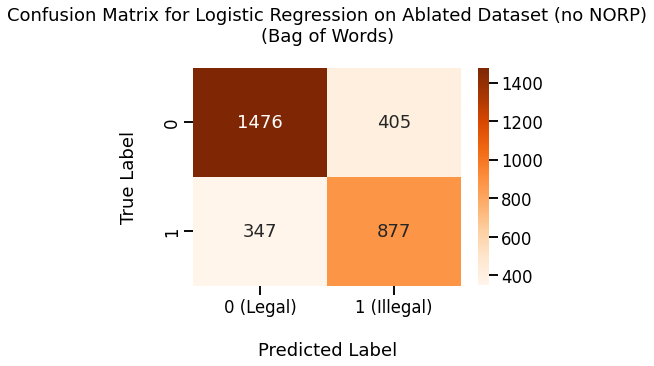

In [47]:
#--------------------------- Pred on test

y_pred = model.predict(vec_x_test)
test_states = []

#--------------------------- Graph confusion matrix of predctions

model_name = 'Logistic Regression on Ablated Dataset (no NORP)\n(Bag of Words)'
describe_performance(model_name, y_test, y_pred, test_states, 
draw_per_state_plots=False)
print('done')

### Fancy confusions for prediction

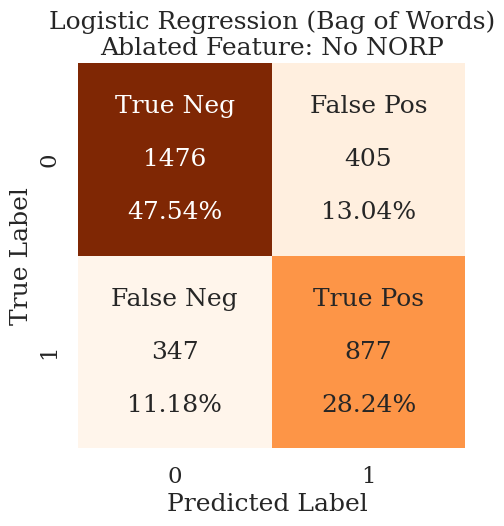

In [48]:
import DTrimarchi10_cf_matrix as fancy_cf
reload(fancy_cf)

labels = ['True Neg\n','False Pos\n','False Neg\n','True Pos\n']
categories = ['0', '1']

sns.reset_defaults()
sns.set_theme(style='darkgrid', context='talk')
a4_dims = (5,5)
plt.rcParams.update({
    "font.family": "Dejavu Serif",
}) 
f, axes = plt.subplots(1,1, figsize=a4_dims)

cf_matrix = confusion_matrix(y_test, y_pred)
g = fancy_cf.make_confusion_matrix(cf_matrix, 
                    group_names=labels,
                    categories=categories, 
                    cmap = 'Oranges',
                    title=f'Logistic Regression (Bag of Words)\nAblated Feature: No NORP',
                    sum_stats=False,
                    xyplotlabels=True,
                    ax=axes,
                    cbar=False
                    )

## Run Logistic Regression for multiple features 

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [50]:
dataset.columns

Index(['pids', 'state', 'text_reviews', 'label', 'no_money', 'no_norp',
       'no_norp_no_lang', 'no_norp_no_lang_no_money'],
      dtype='object')

In [51]:
dataset.sample()

pids state  \
7293  XXX-XXXXXX-XXXXX    VA   

                                           text_reviews  label  \
7293  let me start by say i wa run late from anoth a...      0   

                                               no_money  \
7293  let me start by say i wa run late from anoth a...   

                                                no_norp  \
7293  let me start by say i wa run late from anoth a...   

                                        no_norp_no_lang  \
7293  let me start by say i wa run late from anoth a...   

                               no_norp_no_lang_no_money  
7293  let me start by say i wa run late from anoth a...


 ******************** Feature: text_reviews ******************** 


 ******************** [2022-06-06 05:53:06] Now training model: Logistic Regression
Done Fitting
model name: Logistic Regression (Bag of Words)
Ablated Feature: text_reviews
 accuracy=0.755, precision=0.682, recall=0.706, f1=0.694, mccoef=0.489 


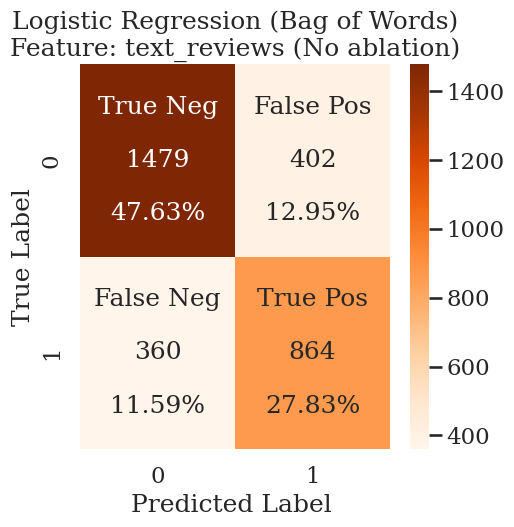


 ******************** Feature: no_money ******************** 


 ******************** [2022-06-06 05:53:28] Now training model: Logistic Regression
Done Fitting
model name: Logistic Regression (Bag of Words)
Ablated Feature: no_money
 accuracy=0.759, precision=0.689, recall=0.708, f1=0.698, mccoef=0.497 


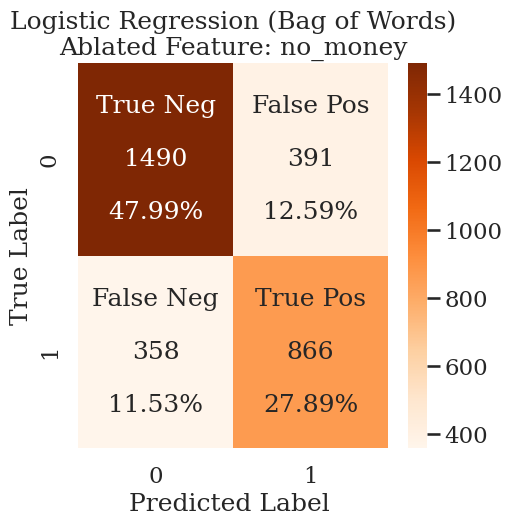


 ******************** Feature: no_norp_no_lang ******************** 


 ******************** [2022-06-06 05:53:51] Now training model: Logistic Regression
Done Fitting
model name: Logistic Regression (Bag of Words)
Ablated Feature: no_norp_no_lang
 accuracy=0.759, precision=0.685, recall=0.717, f1=0.701, mccoef=0.499 


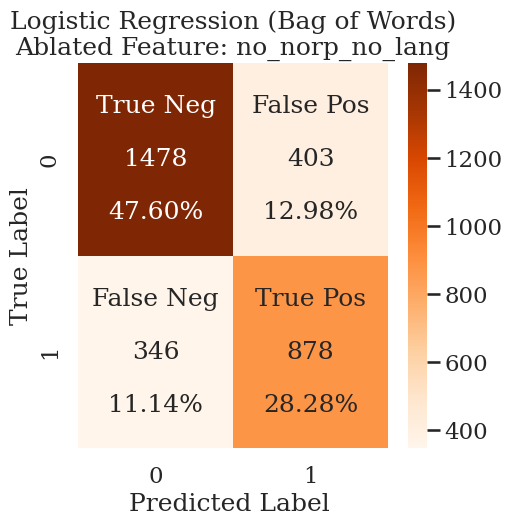


 ******************** Feature: no_norp_no_lang_no_money ******************** 


 ******************** [2022-06-06 05:54:11] Now training model: Logistic Regression
Done Fitting
model name: Logistic Regression (Bag of Words)
Ablated Feature: no_norp_no_lang_no_money
 accuracy=0.758, precision=0.687, recall=0.710, f1=0.698, mccoef=0.497 


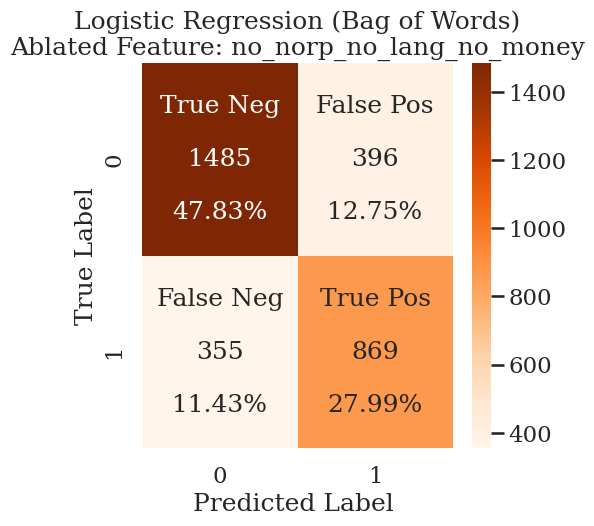

In [52]:
ablations = ['text_reviews', 'no_money', 'no_norp_no_lang', 'no_norp_no_lang_no_money']
ablated_models = {}
ablated_cf_matrices = {}
for feature in ablations:
    print('\n', '*' * 20, f'Feature: {feature}', '*' * 20, '\n')
    X_data = dataset[feature].copy()
    ### ------- Split Data and Turn text into vectors

    X_train, X_test, y_train, y_test = train_test_split(
        X_data, dataset.label,
        stratify=dataset.label, 
        random_state=42,
        test_size=0.25)
    vectorizer = CountVectorizer()
    vectorizer.fit(X_train)

    vec_x_train = vectorizer.transform(X_train)
    vec_x_test = vectorizer.transform(X_test)
    vec_x = vectorizer.transform(X_data)

    ### ------- Train
    model = LogisticRegression(penalty='l1', solver='liblinear', C=10)
    model_name = 'Logistic Regression'

    str_time = str(datetime.datetime.now())[:19]
    print('\n', '*' * 20, f'[{str_time}] Now training model: {model_name}')

    model.fit(vec_x_train, y_train)
    print('Done Fitting')
    ablated_models[feature] = model

    ### ------- Predict  & Describe Performance
    #--- Pred on test

    y_pred = model.predict(vec_x_test)
    test_states = []

    #--- Graph confusion matrix of predctions

    model_name = f'Logistic Regression (Bag of Words)\n' \
                 f'Ablated Feature: {feature}'
    describe_performance(model_name, y_test, y_pred, test_states, 
        dont_plot_big_one=True,
        draw_per_state_plots=False)

    ### ------- Fancy confusions for prediction
    import DTrimarchi10_cf_matrix as fancy_cf
    reload(fancy_cf)

    labels = ['True Neg\n','False Pos\n','False Neg\n','True Pos\n']
    categories = ['0', '1']

    sns.reset_defaults()
    sns.set_theme(style='darkgrid', context='talk')
    a4_dims = (5,5)
    plt.rcParams.update({
        "font.family": "Dejavu Serif",
    }) 
    f, axes = plt.subplots(1,1, figsize=a4_dims)

    cf_matrix = confusion_matrix(y_test, y_pred)
    ablated_cf_matrices[feature] = cf_matrix
    if feature == "text_reviews":
        plot_title=f'Logistic Regression (Bag of Words)\nFeature: {feature} (No ablation)'
    else:
        plot_title=f'Logistic Regression (Bag of Words)\nAblated Feature: {feature}'
    g = fancy_cf.make_confusion_matrix(cf_matrix, 
                        group_names=labels,
                        categories=categories, 
                        cmap = 'Oranges',
                        title=plot_title,
                        sum_stats=False,
                        xyplotlabels=True,
                        ax=axes,
                        cbar=True
                        )
    plt.show()

In [53]:
## all together now (subplots x4 )

In [64]:
print('hi')

hi


1
hi
no_money


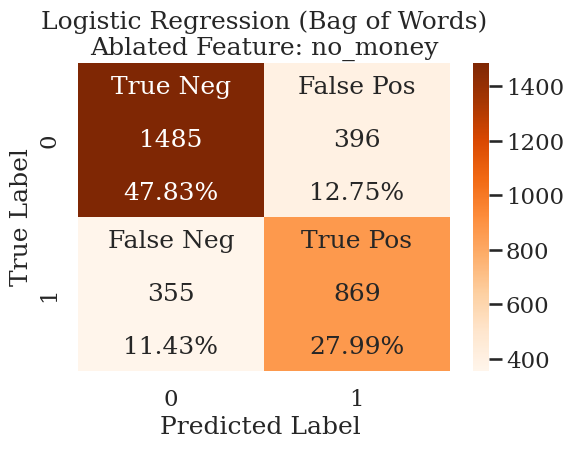

In [85]:
ablations = ['text_reviews', 'no_money', 'no_norp_no_lang', 'no_norp_no_lang_no_money']

ablated_models = {}
confusion_plots = {} # for plotting subplot(2,2) in fture NOTE:

sns.reset_defaults()
sns.set_theme(style='darkgrid', context='talk')
plt.rcParams.update({
    "font.family": "Dejavu Serif",
}) 
### ------- Fancy confusions for prediction
import DTrimarchi10_c_matrix as fancy_cf
reload(fancy_cf)

def calcAblations():
    ablated_cf_matrices = {}
    #for feature in ablations:
    ablations = ['no_money']
    for feature in ablations:
        print('\n', '*' * 20, f'Feature: {feature}', '*' * 20, '\n')
        X_data = dataset[feature].copy()
        ### ------- Split Data and Turn text into vectors

        X_train, X_test, y_train, y_test = train_test_split(
            X_data, dataset.label,
            stratify=dataset.label, 
            random_state=42,
            test_size=0.25)
        vectorizer = CountVectorizer()
        vectorizer.fit(X_train)

        vec_x_train = vectorizer.transform(X_train)
        vec_x_test = vectorizer.transform(X_test)
        vec_x = vectorizer.transform(X_data)

        ### ------- Train
        model = LogisticRegression(penalty='l1', solver='liblinear', C=10)
        model_name = 'Logistic Regression'

        str_time = str(datetime.datetime.now())[:19]
        print('\n', '*' * 20, f'[{str_time}] Now training model: {model_name}')

        model.fit(vec_x_train, y_train)
        print('Done Fitting')
        ablated_models[feature] = model

        ### ------- Predict  & Describe Performance
        #--- Pred on test

        y_pred = model.predict(vec_x_test)
        test_states = []

        #--- Graph confusion matrix of predctions

        model_name = f'Logistic Regression (Bag of Words)\n' \
                    f'Ablated Feature: {feature}'
        describe_performance(model_name, y_test, y_pred, test_states, 
            dont_plot_big_one=True,
            draw_per_state_plots=False)


        labels = ['True Neg\n','False Pos\n','False Neg\n','True Pos\n']
        categories = ['0', '1']


        cf_matrix = confusion_matrix(y_test, y_pred)
        ablated_cf_matrices[feature] = cf_matrix
    return ablated_cf_matrices

if False:
    my_ablated_cf_matrices = calcAblations()
a4_dims = (6,4)

print(len(my_ablated_cf_matrices))
for feature, thing in my_ablated_cf_matrices.items():
    print('hi')
    print(feature)
    f, axes = plt.subplots(1,1, figsize=a4_dims)
    if feature == "text_reviews":
        plot_title=f'Logistic Regression (Bag of Words)\nFeature: {feature} (No ablation)'
    else:
        plot_title=f'Logistic Regression (Bag of Words)\nAblated Feature: {feature}'
    g = fancy_cf.make_confusion_matrix(cf_matrix, 
                        group_names=labels,
                        categories=categories, 
                        cmap = 'Oranges',
                        title=plot_title,
                        sum_stats=False,
                        xyplotlabels=True,
                        ax=axes,
                        cbar=True
                        )
    plt.show()
    #a4_dims = (10,10)
    #f, axes = plt.subplots(2,2, figsize=a4_dims, sharex=True, sharey=True)




In [74]:
def testfxn():
    a = 'serf'
    return a
b = testfxn()


In [75]:
print(b)

serf


# Log Reg (K-Fold)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline

#vec = CountVectorizer()
vec = TfidfVectorizer()
stop_words='english'
clf = LogisticRegressionCV()
pipe = make_pipeline(vec, clf)

RUN_LONG_THING = False
if RUN_LONG_THING:
    pipe.fit(review_train.data, review_train.target)#twenty_train.data, twenty_train.target);